# Analysis of difusion across pru p 3

## Introduction

This notebook is a *start-from-scratch* from the previous notebook since it became to be pretty messy. Basic rules:

1. All new functions and classes are written in the "code" section. Otherwise I have to spend ages trying to recover all the function I need. They will all be run at the beggining of each new analysis
2. It is forbidden to use the same names in consecutive analysis. If the analysis is the same, better create a new function that repeats the analysis.
3. Be clear



## Code

### Imports

In [2]:
import numpy as np
import prody as pdy
import json 
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')
sns.set_palette('Set2')
sys.path.append('C:/Users/Bruno/Dropbox/LTP/pyprobing')
import pyproblib as pyprob
from scipy.signal import argrelextrema

ModuleNotFoundError: No module named 'pyproblib'

### Data pre-processing functions

In [ ]:
def read_1d_pmf(basename, cv_name = 'z'):
    pmf_instance = pd.read_table(
        basename, sep = '\s+', header=None, index_col=False, comment='#'
    )
    pmf_instance.columns = [cv_name, 'PMF']
    return pmf_instance
def read_1d_hills(basename, first_step = 55000, cv_name = 'z'):
    if type(basename) is str :
        print("yey is str")
        hills_instance = pd.read_table(
            basename, sep="\s+", header = None, index_col = False
        )
    elif type(basename) is list :
        tmp = [pd.read_table(i, sep="\s+", header=None, index_col=False) for i in basename]
        hills_instance = pd.concat(tmp, ignore_index=True)
    hills_instance.columns = ['time', cv_name, 'width', 'height']
    hills_instance['time'] -= first_step
    return hills_instance
def read_colvars(basename, first_step = 55000):
    if type(basename) is str:
        colvars_instance = pd.read_table(
            basename, sep="\s+", header = None, index_col = False, comment='#'
        )
    elif type(basename) is list:
        tmp = [
            pd.read_table(i, sep="\s+", header=None, index_col=False, comment='#') 
            for i in basename
        ]
        colvars_instance = pd.concat(tmp, ignore_index=True)
    print(
        "[reading colvars warning] first column is called time. All others are called cv1, cv2,etc"
    )
    try :
        colvars_instance.columns = ['time', 'cv1', 'cv2']
    except ValueError :
        print("WARNING : header has a non trivial structure")
        return colvars_instance
    colvars_instance['time'] -= first_step
    return colvars_instance
def read_dcd(psf_file_name, dcd_file_name, selection = None):
    dcd = pdy.DCDFile(psf_file_name)
    psf = pdy.parsePSF(dcd_file_name)
    dcd.link(psf)
    dcd.setAtoms(psf.select(selection))
    return dcd

### Data analysis functions

#### Energy landscape recovery

In [3]:
def gaussian_sum(height, width, val, spacing = 0.01):
    z_axis = np.arange(val.min() - spacing, val.max() + spacing, 0.1)
    e_axis = np.zeros(z_axis.size)
    for i in range(val.size):
        d = z_axis - val[i]
        e_axis += height[i] * np.exp(-0.5 * (d**2) / ((0.5*width[i])**2))
        #e_axis += height[i] * np.exp(-0.5 * (d**2) / (0.008**2))
    return z_axis, e_axis

def gaussian_iterative_sum(hills_df, times):
    itpmf = []
    z_axis = np.arange(
        hills_df['z'].min() - spacing, 
        hills_df['z'].max() + spacing, 
        0.1
    )
    for t in times : 
        e_axis = np.zeros(z_axis.size)
        tmp = hills_df.query('time < %d' % t)
        val = tmp['z']
        height = tmp['height']
        width = tmp['width']
        for i in range(val.size):
            d = z_axis - val[i]
            e_axis += height[i] * np.exp(-0.5 * (d**2) / ((0.5*width[i])**2))
        itpmf.append(e_axis)
    return z_axis, itpmf

#### Collective variables - analysis of trajectory

#### Mathematical utils

In [4]:
def soften(x, windowsize = 10) :
    y = np.zeros(x.size)
    for i in range(windowsize):
        y[i] = np.mean(x[:i+windowsize])
        y[-(i+1)] = np.mean(x[-i-windowsize:])
    for i in range(windowsize, x.size - windowsize):
        y[i] = np.mean(x[i-windowsize:i+windowsize])
    return y

#### Plotting and representing

In [5]:
def plot_energy_landscape(
    colvar_hills, cv_name='z', bias_temperature=4500, ax = None, label=None
):
    """
    
    """
    Z,E = gaussian_sum(
        colvar_hills['height'], 
        colvar_hills['width'], 
        colvar_hills['z'],
        spacing = 0.1
    )
    E *= -bias_temperature / (bias_temperature + 298.0)
    E -= E.min()
    if ax is None:
        fig, ax = plt.subplots(1)
    if label is None:
        label = 'sim'
    ax.plot(Z,E, label=label + ' $\DeltaT={0}$'.format(bias_temperature))
    ax.set_xlabel(cv_name)
    ax.set_ylabel('pmf ($kcal/mol$)')
    

## Analysis of META 06 simulations

The ensamble of META06 simulations use:
- **Metadynamics bias** along a DistZ colvar oriented at the main difussion axis of the protein
- **Harmonic walls bias** along a DistXY colvar oriented at the main difussion axis of the protein

Two rounds of simulations have been performed: first one is 100ns long and the second, 50ns long.

Code names:
- **t100oA** : time 100ns orientation A 
- **t100oB** : time 100ns orientation B
- **t50oA** : time 50ns orientation A
- **t50oB** : time 50ns orientation B

In [9]:
code_names = ['t100oA', 't100oB', 't50oA', 't50oB']
times = dict(t100oA = 100, t50oA = 50, t100oB = 100, t50oB =50) # ns
orientation = dict(t100oA='A', t50oA='A', t100oB='B', t50oB='B')

paths = dict(
    t100oA ='C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06/',
    t100oB ='C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06/',
    t50oA  ='C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_06_02/',
    t50oB  ='C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_06_02/',
)

hills_files = dict(
    t100oA ='run_06.hills',
    t100oB ='run_06.hills',
    t50oA  ='run_06_02.hills',
    t50oB  ='run_06_02.hills',
)
colvars_files = dict(
    t100oA ='run_06.colvars',
    t100oB ='run_06.colvars',
    t50oA  ='run_06_02.colvars',
    t50oB  ='run_06_02.colvars',
)


### Visualization of energy landscapes for all trajectories

Energy landscapes will be stored in a same pandas dataframe (energy_landscape_df)

In [37]:
bias_temperature = 4500 # Kelvin
sim_temperature = 298
try :
    del energy_landscape_df
except NameError:
    pass

for code in code_names :
    tmp_hills = read_1d_hills(basename=paths[code] + hills_files[code])
    Z,E = gaussian_sum(
        tmp_hills['height'], tmp_hills['width'], 
        tmp_hills['z'], 0.1
    )
    E_c = E*(-bias_temperature /(sim_temperature + bias_temperature)) 
    E_c -= E_c.min()
    tmp = pd.DataFrame.from_items(
        [
            ('distZ', Z), # distance on z axis
            ('pmf', E_c), # kcal/mol
            ('potential', E),
            ('orientation', orientation[code]), # orientation
            ('sim_time', times[code]) # simulation time
        ]
    )
    try :
        energy_landscape_df = pd.concat((tmp, energy_landscape_df))
    except NameError :
        energy_landscape_df = tmp.copy()
    del tmp_hills, Z, E, tmp

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


In [38]:
energy_landscape_df[:10]

,distZ,pmf,potential,orientation,sim_time
0,-40.110656,27.154483,0.045783,B,50
1,-40.010656,27.103633,0.100000,B,50
2,-39.910656,27.154412,0.045859,B,50
3,-39.810656,27.189557,0.008386,B,50
4,-39.710656,27.154068,0.046226,B,50
5,-39.610656,27.070025,0.135833,B,50
6,-39.510656,27.060281,0.146223,B,50
7,-39.410656,27.140103,0.061115,B,50
8,-39.310656,27.183779,0.014546,B,50
9,-39.210656,27.141479,0.059648,B,50


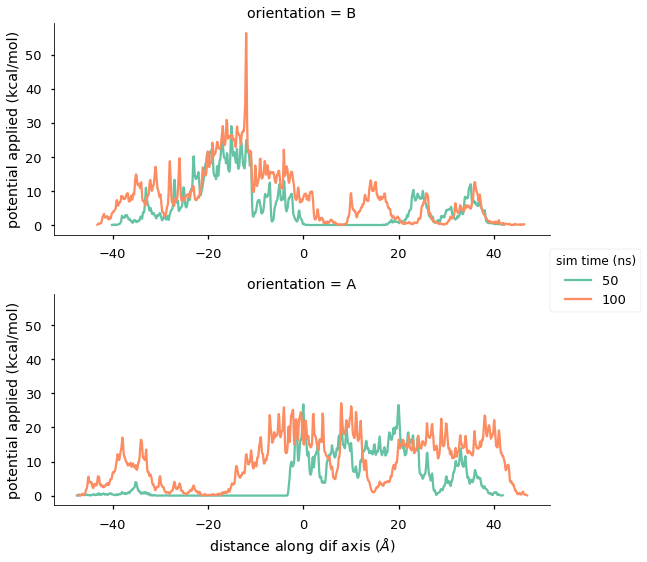

In [40]:
g = sns.FacetGrid(
    hue='sim_time', row = 'orientation', 
    data = energy_landscape_df, size=4, aspect=2.0
)
g.map(plt.plot, 'distZ', 'potential')
g.add_legend(title='sim time (ns)')
g.set_ylabels('potential applied (kcal/mol)')
g.set_xlabels('distance along dif axis ($\AA$)')
plt.savefig('C:/Users/Bruno/Dropbox/LTP/fig/tunnel/all_energy_landscapes.png', dpi=300 )
plt.show()

So far, this looks awful. Let's try to observe the landscapes only until the unbinding

In [44]:
unbinding_times = dict(
    t50oB =596000,
    t50oA =1092000,
    t100oA=1906000,
    t100oB=1514000
)

In [45]:
try :
    del truncated_energy_landscape_df
except NameError:
    pass

for code in code_names :
    tmp_hills = read_1d_hills(basename=paths[code] + hills_files[code])
    tmp_hills.query('time < {0}'.format(unbinding_times[code]), inplace = True)
    Z,E = gaussian_sum(
        tmp_hills['height'], tmp_hills['width'], 
        tmp_hills['z'], 0.1
    )
    E_c = E*(-bias_temperature /(sim_temperature + bias_temperature)) 
    E_c -= E_c.min()
    tmp = pd.DataFrame.from_items(
        [
            ('distZ', Z), # distance on z axis
            ('pmf', E_c), # kcal/mol
            ('potential', E),
            ('orientation', orientation[code]), # orientation
            ('sim_time', times[code]) # simulation time
        ]
    )
    try :
        truncated_energy_landscape_df = pd.concat((tmp, truncated_energy_landscape_df))
    except NameError :
        truncated_energy_landscape_df = tmp.copy()
    del tmp_hills, Z, E, tmp

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


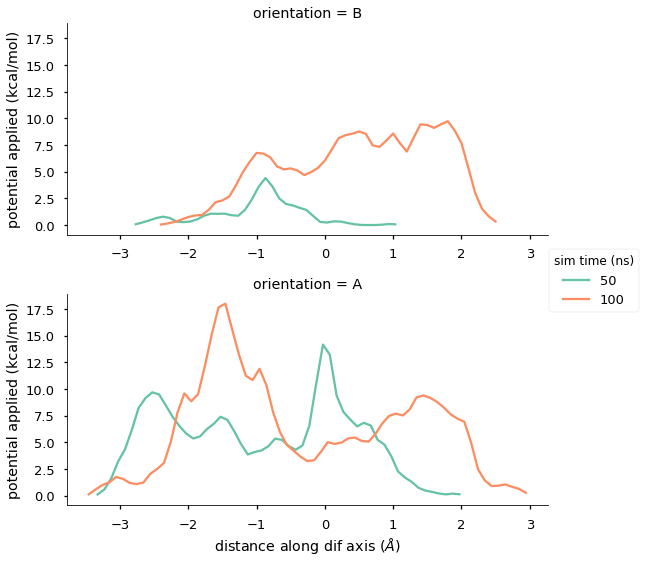

In [47]:
g = sns.FacetGrid(
    hue='sim_time', row = 'orientation', 
    data = truncated_energy_landscape_df, size=4, aspect=2.0
)
g.map(plt.plot, 'distZ', 'potential')
g.add_legend(title='sim time (ns)')
g.set_ylabels('potential applied (kcal/mol)')
g.set_xlabels('distance along dif axis ($\AA$)')
plt.savefig(
    'C:/Users/Bruno/Dropbox/LTP/fig/tunnel/all_energy_landscapes_truncated.png', dpi=300
)
plt.show()

## Setting a z-distance restrained simulation

By now the largest problem I am facing is that most of my simulation time is spent on... nothing. Just a molecule moving in the water. This is why now I'll set harmonic walls in the the z distance. But this time I wont' make any mistake: values for these restraints will be set according to the previous NAMD runs.

### META09 on ligA/RUN06

In [14]:
ligA_06_colvars = pd.read_table(
    'C:/scratch/RUN_09_ON_06_A.dat', sep="\s+", header = None, names = ['z', 'r']
)
ligB_06_colvars = pd.read_table(
    'C:/scratch/RUN_09_ON_06_B.dat', sep="\s+", header = None, names = ['z', 'r']
)

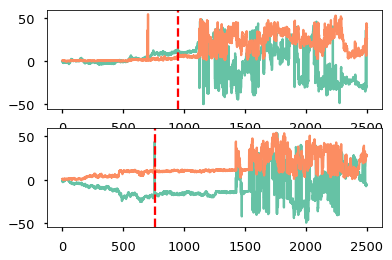

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(ligA_06_colvars['z'])
ax[0].plot(ligA_06_colvars['r'])
ax[0].axvline(953, color = 'red', linestyle = '--')
ax[1].plot(ligB_06_colvars['z'])
ax[1].plot(ligB_06_colvars['r'])
ax[1].axvline(757, color = 'red', linestyle = '--')
plt.show()

## Analysis of z-distance restrained sim (META09)

In this simulation, harmonic walls were included to avoid the ligand escaping into the solvent, making simulation time useless.

In [7]:
ligA_09_colvars = read_colvars(
    [
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1.colvars',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1_02.colvars',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1_03.colvars'
    ]
)
ligA_09_colvars.columns = ['steps', 'z', 'xy', 'E_cilinder', 'E_cover']
ligA_09_colvars['steps'] -= 55000
ligA_09_colvars['time'] = ligA_09_colvars['steps'] * 2e-6

ligB_09_colvars = read_colvars(
    [
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_01.colvars',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_02.colvars',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_03.colvars',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_04.colvars'
    ]
)
ligB_09_colvars.columns = ['steps', 'z', 'xy', 'E_cilinder', 'E_cover']
ligB_09_colvars['steps'] -= 55000
ligB_09_colvars['time'] = ligB_09_colvars['steps'] * 2e-6

ligA_09_colvars[-10:]

[reading colvars warning] first column is called time. All others are called cv1, cv2,etc
[reading colvars warning] first column is called time. All others are called cv1, cv2,etc


,steps,z,xy,E_cilinder,E_cover,time
199993,99995500,3.636251,1.214112,0.0,0.0,199.991
199994,99996000,3.637851,1.904262,0.0,0.0,199.992
199995,99996500,3.502197,1.930432,0.0,0.0,199.993
199996,99997000,3.568527,1.699764,0.0,0.0,199.994
199997,99997500,3.873230,1.916988,0.0,0.0,199.995
199998,99998000,3.615964,1.756309,0.0,0.0,199.996
199999,99998500,3.556354,1.562374,0.0,0.0,199.997
200000,99999000,3.464056,1.499680,0.0,0.0,199.998
200001,99999500,3.696965,1.960690,0.0,0.0,199.999
200002,100000000,3.752663,1.698466,0.0,0.0,200.000


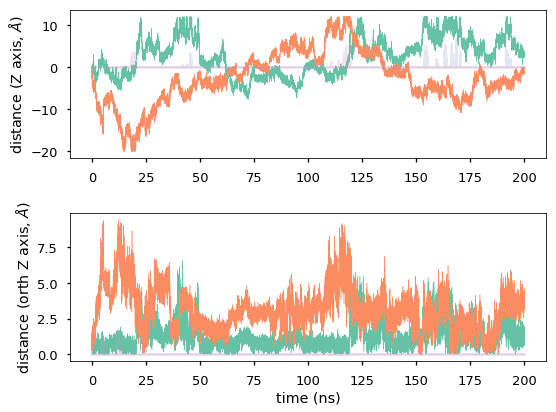

In [8]:
fig, ax = plt.subplots(2)
fig.set_size_inches(8,6)
ax[0].plot(ligA_09_colvars['time'], ligA_09_colvars['z'], linewidth = 0.5)
ax[0].plot(ligB_09_colvars['time'], ligB_09_colvars['z'], linewidth = 0.5)
ax[0].plot(ligA_09_colvars['time'], ligA_09_colvars['E_cover'], alpha = 0.25)
ax[0].plot(ligB_09_colvars['time'], ligB_09_colvars['E_cover'], alpha = 0.25)
ax[1].plot(ligA_09_colvars['time'], ligA_09_colvars['xy'], linewidth = 0.5)
ax[1].plot(ligB_09_colvars['time'], ligB_09_colvars['xy'], linewidth = 0.5)
ax[1].plot(ligA_09_colvars['time'], ligA_09_colvars['E_cilinder'], alpha = 0.25)
ax[1].plot(ligB_09_colvars['time'], ligB_09_colvars['E_cilinder'], alpha = 0.25)
ax[1].set_xlabel('time (ns)')
ax[0].set_ylabel('distance (Z axis, $\AA$)')
ax[1].set_ylabel('distance (orth Z axis, $\AA$)')
fig.tight_layout()
plt.show()

So we can observe that there is not a ligand run out and that forces applied are just puntual. Now let's take a look at the hills

In [9]:
ligB_09_colvars.loc[0]

steps         0.000000
z            -1.094976
xy            0.707959
E_cilinder    0.000000
E_cover       0.000000
time          0.000000
Name: 0, dtype: float64

In [10]:
ligA_09_hills  = read_1d_hills(
    [
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1.hills',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1_02.hills',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1_03.hills'
    ]
)
ligA_09_hills['step']  = ligA_09_hills['time']
ligA_09_hills['time'] = ligA_09_hills['step'] * 2e-6

ligB_09_hills  = read_1d_hills(
    [
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_01.hills',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_02.hills',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_03.hills',
        'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_04.hills'
    ]
)
ligB_09_hills['step']  = ligB_09_hills['time']
ligB_09_hills['time'] = ligB_09_hills['step'] * 2e-6


ligA_09_hills[:10]

,time,z,width,height,step
0,0.000,-0.883251,0.062666,0.100000,0
1,0.001,-1.168125,0.062666,0.100000,500
2,0.002,-1.134263,0.062666,0.099567,1000
3,0.003,-1.075333,0.062666,0.099801,1500
4,0.004,-1.227858,0.062666,0.099768,2000
5,0.005,-0.580744,0.062666,0.100000,2500
6,0.006,-0.567878,0.062666,0.098906,3000
7,0.007,-0.556170,0.062666,0.097846,3500
8,0.008,-1.199899,0.062666,0.098171,4000
9,0.009,-0.672349,0.062666,0.099984,4500


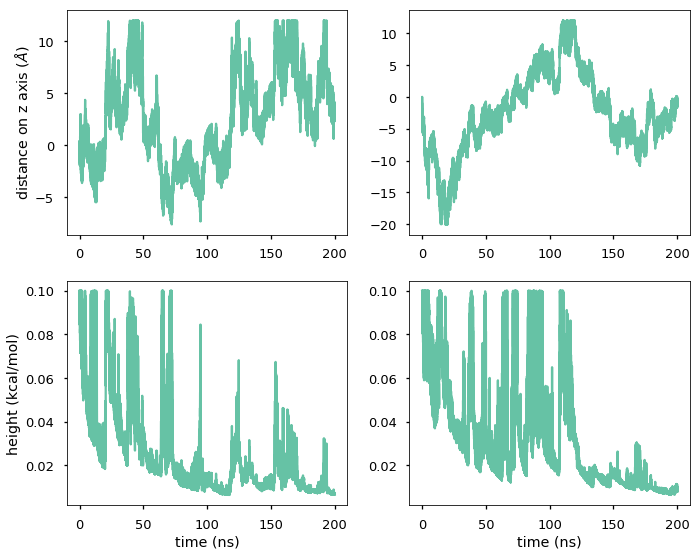

In [11]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(10,8)
ax[0,0].plot(ligA_09_hills['time'], ligA_09_hills['z'])
ax[1,0].plot(ligA_09_hills['time'], ligA_09_hills['height'])
ax[0,1].plot(ligB_09_hills['time'], ligB_09_hills['z'])
ax[1,1].plot(ligB_09_hills['time'], ligB_09_hills['height'])
ax[0,0].set_ylabel('distance on z axis ($\AA$)')
ax[1,0].set_ylabel('height (kcal/mol)')
ax[1,0].set_xlabel('time (ns)')
ax[1,1].set_xlabel('time (ns)')
fig.tight_layout()
plt.show()

It seems that energy addition decreases monotonically at the beggining, then there is another  state where this happens, and then all other new states have sudden changes, which would mean that the bassin is filled before the gaussian height reaches 0. That is good.

In [11]:
Z_A,E_A = gaussian_sum(
    height=ligA_09_hills['height'],
    spacing=1.0, 
    width=ligA_09_hills['width'], 
    val=ligA_09_hills['z']
)
bias_temperature = 4500
sim_temperature = 298
E_Ac = E_A/(-bias_temperature /(sim_temperature + bias_temperature)) 
E_Ac -= E_Ac.min()

Z_B,E_B = gaussian_sum(
    height=ligB_09_hills['height'],
    spacing=1.0, 
    width=ligB_09_hills['width'], 
    val=ligB_09_hills['z']
)
bias_temperature = 4500
sim_temperature = 298
E_Bc = E_B/(-bias_temperature /(sim_temperature + bias_temperature)) 
E_Bc -= E_Bc.min()


In [12]:
E_Ac_series = pd.Series(E_Ac)
E_Bc_series = pd.Series(E_Bc)

soften_A = E_Ac_series.rolling(window=20, center=True).mean()
soften_B = E_Bc_series.rolling(window=20, center=True).mean()

XA = argrelextrema(-soften_A.values, np.less)[0]
XB = argrelextrema(-soften_B.values, np.less)[0]


C:\Users\Bruno\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:73: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, plus)
C:\Users\Bruno\Anaconda3\lib\site-packages\scipy\signal\_peak_finding.py:74: RuntimeWarning: invalid value encountered in less
  results &= comparator(main, minus)


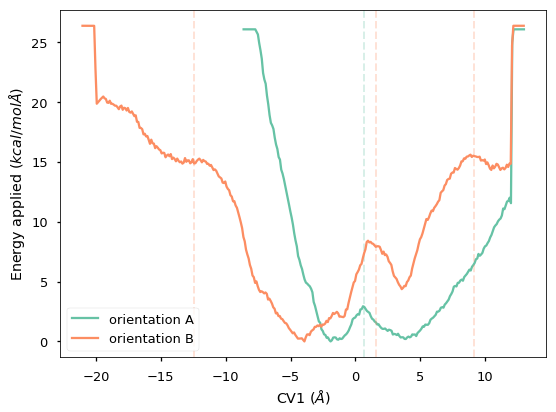

In [13]:
cmp = sns.color_palette('Set2')
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
#ax.plot(Z_A,soften_A, label = 'orientation A')
ax.plot(Z_A,E_Ac, label = 'orientation A')
for i in range(XA.size):
    ax.axvline(Z_A[XA[i]], linewidth=2.0, linestyle='--', color=cmp[0], alpha = 0.25)
ax.plot(Z_B,E_Bc, label = 'orientation B')
for i in range(XB.size):
    ax.axvline(Z_B[XB[i]], linewidth=2.0, linestyle='--', color=cmp[1], alpha = 0.25)
ax.legend()
ax.set_ylabel('Energy applied ($kcal/mol\AA$)')
ax.set_xlabel('CV1 ($\AA$)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figure4.png', dpi=300)
plt.show()

Oh I'm pretty shocked right now. Are there no bassins?

In [14]:
ligA_09_pmf = read_1d_pmf(
    basename='C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1_03.pmf'
)

ligB_09_pmf = read_1d_pmf(
    basename='C:/Users/Bruno/Dropbox/LTP/METAMD/prup3/ligB/data/run_09/meta_09_04.pmf'
)

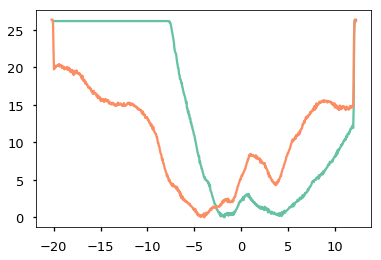

In [15]:
fig, ax = plt.subplots(1)
ax.plot(ligA_09_pmf['z'], ligA_09_pmf['PMF'])
ax.plot(ligB_09_pmf['z'], ligB_09_pmf['PMF'])
plt.show()

In [17]:
spacing = 0.1
Z, I = gaussian_iterative_sum(hills_df=ligA_09_hills, times=[100.0, 150.0, 175.0, 187.5, 200.0])

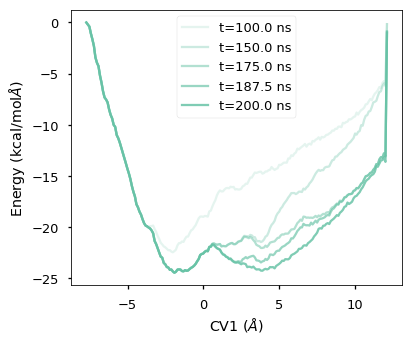

In [19]:
ccc = sns.color_palette('Set2')[0]
labs = ['t=%4.1f ns'% i for i  in [100.0, 150.0, 175.0, 187.5, 200.0]]
fig, ax = plt.subplots(1)
fig.set_size_inches(6,5)
for i, (l, E) in enumerate(zip(labs, I)):
    ax.plot(Z, -E, color = ccc, label=l, alpha = (i +1) / 6.0)
ax.legend()
ax.set_ylabel('Energy (kcal/mol$\AA$)')
ax.set_xlabel('CV1 ($\AA$)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figure5A.png')
plt.show()

In [20]:
Z, I = gaussian_iterative_sum(hills_df=ligB_09_hills, times=[100.0, 150.0, 175.0, 187.5, 200.0])

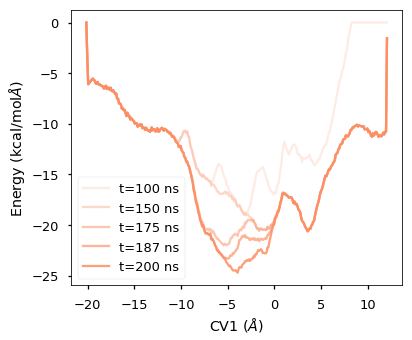

In [21]:
ccc = sns.color_palette('Set2')[1]
labs = ['t=%d ns'% i for i  in [100.0, 150.0, 175.0, 187.5, 200.0]]
fig, ax = plt.subplots(1)
fig.set_size_inches(6,5)
for i, (l, E) in enumerate(zip(labs, I)):
    ax.plot(Z, -E, color = ccc, label=l, alpha = (i+1)/6.0)
ax.legend()
ax.set_ylabel('Energy (kcal/mol$\AA$)')
ax.set_xlabel('CV1 ($\AA$)')
plt.tight_layout()
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figure5B.png')
plt.show()

### Trajectory analysis of run_09

In [12]:
ligA_09_dcd = pdy.DCDFile('F:/DM/run2/metadm/ligA/wtmetamd/run_09/run_09_v1.dcd')
ligB_09_dcd = pdy.DCDFile('F:/DM/run2/metadm/ligB/wtmetamd/run_09/run_09.dcd')
ligA_09_psf = pdy.parsePSF('C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/input/ligA_bb.psf')
ligB_09_psf = pdy.parsePSF('C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/input/ligB_bb.psf')
ligA_09_dcd.link(ligA_09_psf)
ligB_09_dcd.link(ligB_09_psf)

### Analysis of the C-tail

C tail shows a large variability in the trajectories. Therefore, we want to characterize the variation of this part of the protein in the metadynamics trajectories to know its relation with ligand movement.

In [8]:
selection_c_tail = 'backbone and resnum 79 to 91'
rmsd_tail = np.zeros((ligA_09_dcd.numFrames(), 2), dtype='float64')
rgyr_tail = np.zeros((ligA_09_dcd.numFrames(), 2), dtype='float64')
rmsd_protein = np.zeros((ligA_09_dcd.numFrames(), 2), dtype='float64')
rgyr_protein = np.zeros((ligA_09_dcd.numFrames(), 2), dtype='float64')
psi_cys87 = np.zeros((ligA_09_dcd.numFrames(), 2), dtype='float64')

In [10]:
ref_A = pdy.parsePDB('C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/input/ligA_bb_w.pdb')
ref_B = pdy.parsePDB('C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/input/ligB_bb_w.pdb')

@> 36958 atoms and 1 coordinate set(s) were parsed in 0.29s.
@> 36967 atoms and 1 coordinate set(s) were parsed in 0.31s.


In [26]:
for i, (frame_A, frame_B) in enumerate(zip(ligA_09_dcd, ligB_09_dcd)):
    coords_A = frame_A.getAtoms()
    coords_B = frame_B.getAtoms()
    tail_A = coords_A.select(selection_c_tail)
    tail_B = coords_B.select(selection_c_tail)
    protein_A = coords_A.select('protein and backbone')
    protein_B = coords_B.select('protein and backbone')
    
    rgyr_tail[i,0] = pdy.calcGyradius(tail_A)
    rgyr_tail[i,1] = pdy.calcGyradius(tail_B)
    rgyr_protein[i, 0] = pdy.calcGyradius(protein_A)
    rgyr_protein[i, 1] = pdy.calcGyradius(protein_B)
    
    rot_A_protein,_ = pdy.superpose(protein_A, ref_A.select('protein and backbone'))
    rot_B_protein,_ = pdy.superpose(protein_B, ref_B.select('protein and backbone'))
    
    rot_A_tail,_ = pdy.superpose(tail_A, ref_A.select(selection_c_tail))
    rot_B_tail,_ = pdy.superpose(tail_B, ref_B.select(selection_c_tail))
    
    rmsd_protein[i,0] = pdy.calcRMSD(ref_A.select('protein and backbone'), rot_A_protein)
    rmsd_protein[i,1] = pdy.calcRMSD(ref_B.select('protein and backbone'), rot_B_protein)
    
    rmsd_tail[i, 0] = pdy.calcRMSD(rot_A_tail, ref_A.select(selection_c_tail))
    rmsd_tail[i, 1] = pdy.calcRMSD(rot_B_tail, ref_B.select(selection_c_tail))
    
    hv_A = coords_A.getHierView()
    hv_B = coords_B.getHierView()
    
    psi_cys87[i,0] = pdy.calcPsi(hv_A.getResidue(resnum=87, chid='', segname='PROA'))
    psi_cys87[i,1] = pdy.calcPsi(hv_B.getResidue(resnum=87, chid='', segname='PROA'))

C:\Users\Bruno\Anaconda3\lib\site-packages\prody\atomic\subset.py:35: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  elif not np.issubdtype(indices.dtype, int):
C:\Users\Bruno\Anaconda3\lib\site-packages\prody\measure\measure.py:203: RuntimeWarning: invalid value encountered in arccos
  rad = arccos((v1*v2).sum(-1) / ((v1**2).sum(-1) * (v2**2).sum(-1))**0.5)


In [27]:
t = np.arange(5000) * 0.04

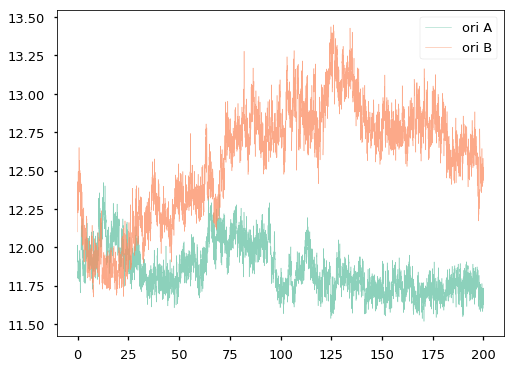

In [28]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.plot(t,rgyr_protein[:,0], label = 'ori A', alpha = 0.75, linewidth=0.5)
ax.plot(t,rgyr_protein[:,1], label = 'ori B', alpha = 0.75, linewidth=0.5)
ax.legend()
plt.show()

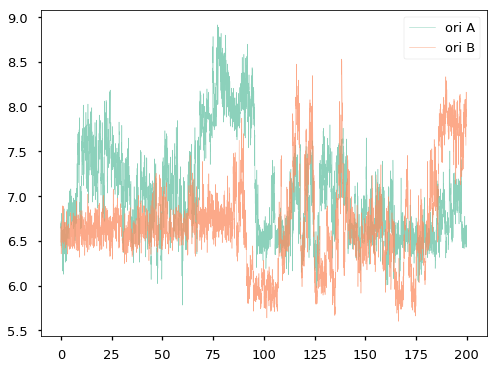

In [29]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.plot(t,rgyr_tail[:,0], label = 'ori A', alpha = 0.75, linewidth=0.5)
ax.plot(t,rgyr_tail[:,1], label = 'ori B', alpha = 0.75, linewidth=0.5)
ax.legend()
plt.show()

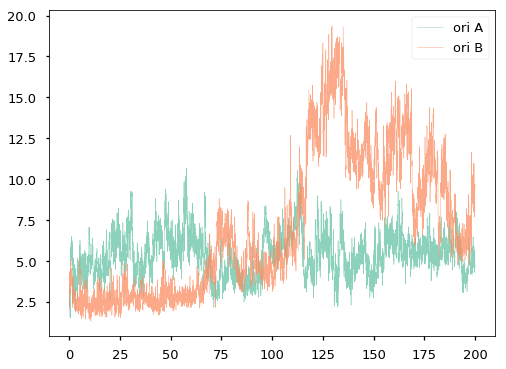

In [30]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.plot(t,rmsd_protein[:,0], label = 'ori A', alpha = 0.75, linewidth=0.5)
ax.plot(t,rmsd_protein[:,1], label = 'ori B', alpha = 0.75, linewidth=0.5)
ax.legend()
plt.show()

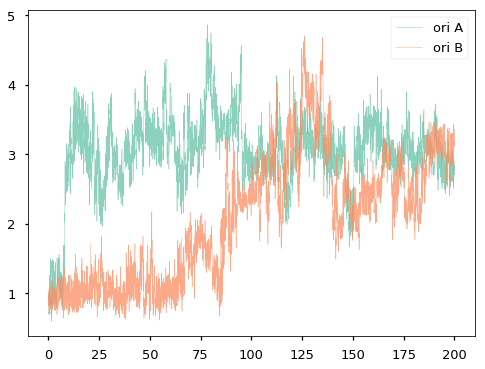

In [31]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.plot(t,rmsd_tail[:,0], label = 'ori A', alpha = 0.75, linewidth=0.5)
ax.plot(t,rmsd_tail[:,1], label = 'ori B', alpha = 0.75, linewidth=0.5)
ax.legend()
plt.show()

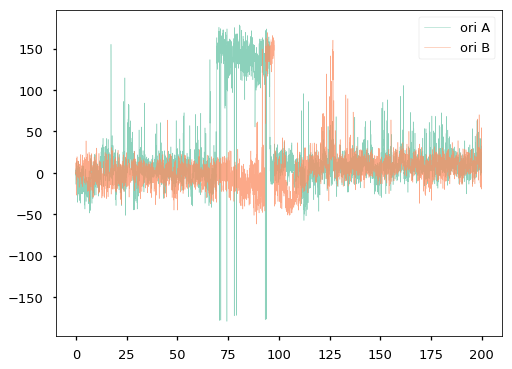

In [32]:
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.plot(t,psi_cys87[:,0], label = 'ori A', alpha = 0.75, linewidth=0.5)
ax.plot(t,psi_cys87[:,1], label = 'ori B', alpha = 0.75, linewidth=0.5)
ax.legend()
plt.show()

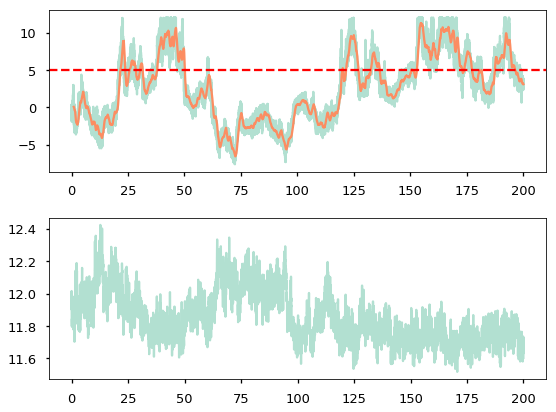

In [33]:
fig, ax = plt.subplots(2,1)
fig.set_size_inches(8,6)
ax[0].plot(ligA_09_colvars['time'], ligA_09_colvars['z'], alpha = 0.5)
ax[0].plot(ligA_09_colvars['time'], ligA_09_colvars['z'].rolling(window = 1000).mean(), linestyle='-')
ax[1].plot(t, rgyr_protein[:,0], alpha = 0.5)
ax[0].axhline(5.0, color = 'red', linestyle='--')
plt.tight_layout()
plt.show()

In [34]:
from scipy.stats import pearsonr

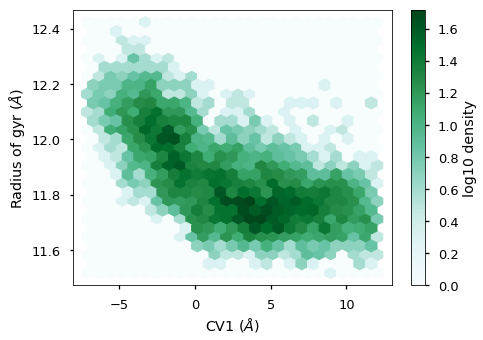

In [37]:
fig, ax = plt.subplots(1)
fig.set_size_inches(7,5)
cm = ax.hexbin(
    ligA_09_colvars['z'][:-4].values[::40], 
    rgyr_protein[:,0], 
    bins='log', 
    gridsize=25, 
    cmap='BuGn'
)
ax.set_ylabel('Radius of gyr ($\AA$)')
ax.set_xlabel('CV1 ($\AA$)')
cb = fig.colorbar(cm)
cb.set_label('log10 density')
fig.tight_layout()
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figureS1.png', dpi=300)
plt.show()

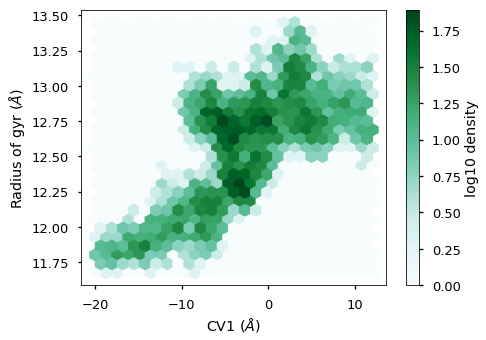

In [38]:
fig, ax = plt.subplots(1)
fig.set_size_inches(7,5)
cm = ax.hexbin(
    ligB_09_colvars['z'][:-4].values[::40], 
    rgyr_protein[:,1], 
    bins='log', 
    gridsize=25, 
    cmap='BuGn'
)
ax.set_ylabel('Radius of gyr ($\AA$)')
ax.set_xlabel('CV1 ($\AA$)')
cb = fig.colorbar(cm)
cb.set_label('log10 density')
fig.tight_layout()
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figureS2.png', dpi=300)
plt.show()

In [13]:
coordnum_A = pd.read_csv(
    'C:/scratch/coord_number/coord_num.csv', sep="\s+", header = None, names = ['timestep', 'coordNum']
)
coordnum_B = pd.read_csv(
    'C:/scratch/coord_number/coord_B.csv', sep="\s+", header = None, names = ['timestep', 'coordNum']
)

short_colvars_A = pd.read_csv(
    'C:/scratch/coord_number/meta_09_short.colvars', names = ['z', 'xy'], sep ="\s+"
)
short_colvars_B = pd.read_csv(
    'C:/scratch/coord_number/meta_09_shortB.colvars', names = ['z', 'xy'], sep = "\s+"
)

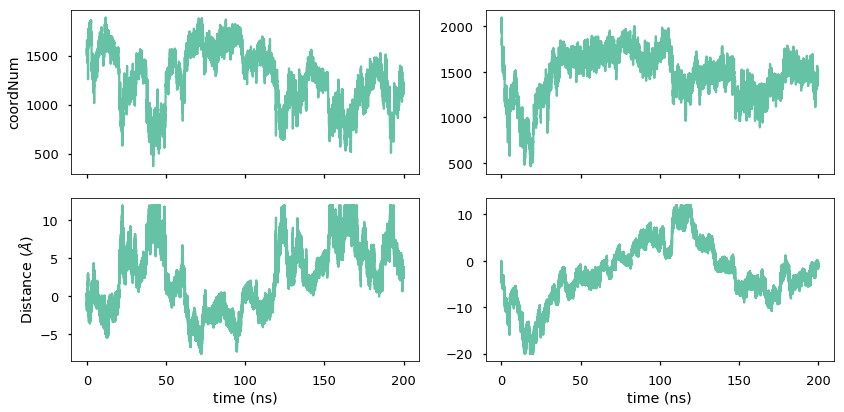

In [14]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=False)
fig.set_size_inches(12,6)
ax[0,0].plot(np.arange(5000) * 0.04, coordnum_A['coordNum'])
ax[1,0].plot(ligA_09_colvars['time'], ligA_09_colvars['z'])
ax[0,1].plot(np.arange(5000) * 0.04, coordnum_B['coordNum'])
ax[1,1].plot(ligB_09_colvars['time'], ligB_09_colvars['z'])
ax[0,0].set_ylabel('coordNum')
ax[1,0].set_ylabel('Distance ($\AA$)')
ax[1,0].set_xlabel('time (ns)')
ax[1,1].set_xlabel('time (ns)')
fig.tight_layout()
plt.show()

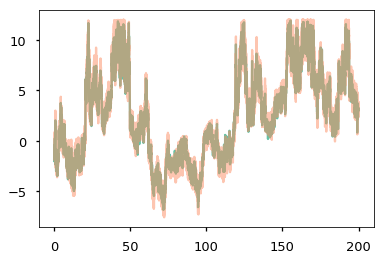

In [15]:
plt.plot(np.arange(5000)*0.04, short_colvars_A['z'])
plt.plot(ligA_09_colvars['time'], ligA_09_colvars['z'], alpha = 0.5)
plt.show()

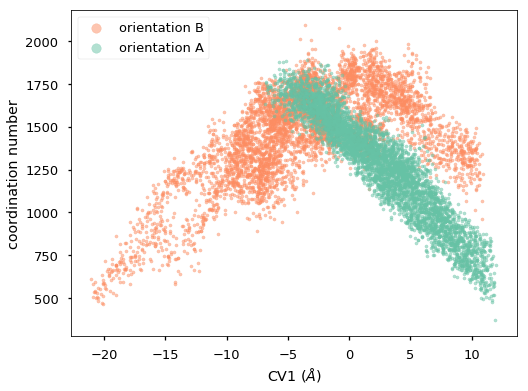

In [16]:
cmp = sns.color_palette('Set2')
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.scatter(
    short_colvars_B['z'], coordnum_B['coordNum'], s = 10, label = 'orientation B', alpha=0.5,
    color = cmp[1]
)
ax.scatter(
    short_colvars_A['z'], coordnum_A['coordNum'], s = 10, label = 'orientation A', alpha=0.5,
    color = cmp[0]
)
ax.legend(markerscale =3)
ax.set_ylabel('coordination number')
ax.set_xlabel('CV1 ($\AA$)')
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figure7.png')
plt.show()

In [18]:
pockets_A = pd.read_table(
    'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligA/data/run_09/meta_09_v1_pockets.dat', sep ="\s+"
)
pockets_B = pd.read_table(
    'C:/Users/Bruno/ownCloud/projects/LTP/METAMD/prup3/ligB/data/run_09/meta_09_pockets.dat', sep ="\s+"
)

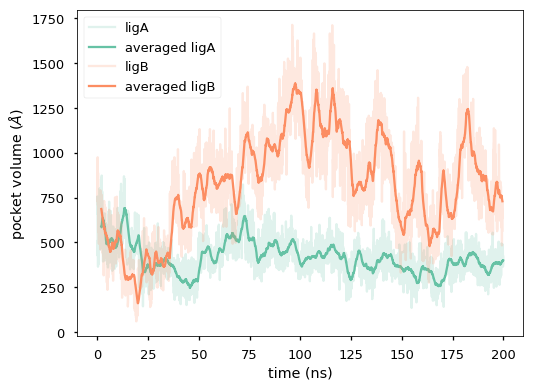

In [19]:
set2_colors = sns.color_palette('Set2')

fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.plot(np.arange(5000) * 0.04, pockets_A['Volume'], alpha = 0.2, color =set2_colors[0], label = 'ligA')
ax.plot(np.arange(5000) * 0.04, pockets_A['Volume'].rolling(window=50).mean(), label='averaged ligA')
ax.plot(np.arange(4991) * 0.04, pockets_B['Volume'], alpha = 0.2, color = set2_colors[1], label = 'ligB')
ax.plot(np.arange(4991) * 0.04, pockets_B['Volume'].rolling(window=50).mean(), label = 'averaged ligB')
ax.legend()
ax.set_xlabel('time (ns)')
ax.set_ylabel('pocket volume ($\AA$)')
plt.show()

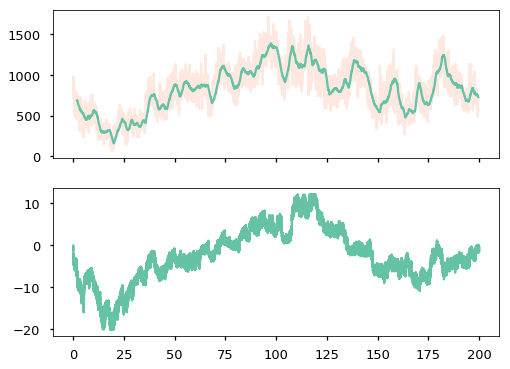

In [20]:
fig, ax = plt.subplots(2,1, sharex=True)
fig.set_size_inches(8,6)
ax[0].plot(
    np.arange(4991) * 0.04, pockets_B['Volume'], 
    alpha = 0.2, color = set2_colors[1], label = 'ligB'
)
ax[0].plot(
    np.arange(4991) * 0.04, pockets_B['Volume'].rolling(window=50).mean(), 
    label = 'averaged ligB'
)
ax[1].plot(
    ligB_09_colvars['time'], ligB_09_colvars['z']
)
plt.show()

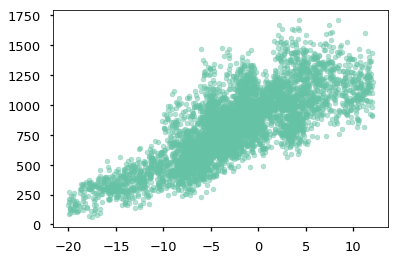

In [21]:
plt.scatter(
    ligB_09_colvars['z'].values[::40][:4991],
    pockets_B['Volume'], alpha = 0.5, s = 25
)
plt.show()

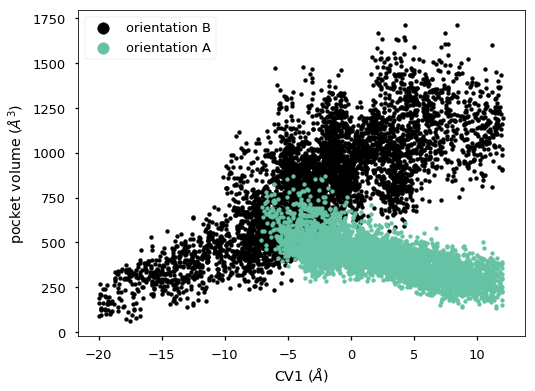

In [29]:
cmp = sns.color_palette('Set2')
fig, ax = plt.subplots(1)
fig.set_size_inches(8,6)
ax.scatter(
    ligB_09_colvars['z'].values[::40][:4991],
    pockets_B['Volume'], alpha = 1.0, s = 15, label = 'orientation B', color = 'black'
)
ax.scatter(
    ligA_09_colvars['z'].values[::40][:-1],
    pockets_A['Volume'], alpha = 1.0, s = 15, label = 'orientation A', color = cmp[0]
)

ax.legend(markerscale=3)
ax.set_ylabel('pocket volume ($\AA^{3}$)')
ax.set_xlabel('CV1 ($\AA$)')
plt.savefig('C:/Users/Bruno/ownCloud/publication/ltp_2019/figure6.png')
plt.show()

In [28]:
ligA_09_colvars['z'].values[::40].shape

NameError: name 'ligA_09_colvars' is not defined